In [1]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import math
import os

from moviepy.editor import VideoFileClip
from IPython.display import HTML
import datetime

In [2]:
%%HTML
<style> code {background-color : orange !important;} </style>
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
def GlobalCandidates():
    fileNameBase = "project_video"
    fileExtIn = ".mp4"
    fileExtOut = "jpg"
    dirIn = "ImagesIn/VideosIn/"
    dirOut = "ImagesIn/VideosIn/" + fileNameBase + "_frames/"
    fileNameIn  = dirIn + fileNameBase + fileExtIn
    fileNameOutFmt = dirOut + fileNameBase + "_f{:04}." + fileExtOut
    
    #if (not os.path.exists(dirOut)):
    #    os.makedirs(dirOut)


In [59]:
#calFileInNames = glob.glob('camera_cal/cal*.jpg')
#calFileInNames = ['camera_cal/calibration2.jpg']

def GetImageIteratorFromDir():
    dirImagesIn = "ImagesIn/TestImagesIn/POVRaw/"
    fileNameBase = "straight_lines1.jpg"

    #imgInFileNames = [dirImagesIn + "straight_lines1.jpg", dirImagesIn + "straight_lines2.jpg"]
    imgInFileNames = [dirImagesIn + "straight_lines1.jpg", dirImagesIn + "straight_lines1.jpg"]
    imgInFileNames = [dirImagesIn + "straight_lines1.jpg"]
    imageIter = ((mpimg.imread(imgInFileName), imgInFileName) for imgInFileName in imgInFileNames)

    return(imageIter)

In [43]:
def ImageProc_Pipeline(imgRaw):
    dirImagesIn = "ImagesIn/TestImagesIn/PipelineStages/"
    imgInFileNameBase = "warped_example.jpg"
    imgInFileName = dirImagesIn + imgInFileNameBase

    imgPipeProc = mpimg.imread(imgInFileName)
    return imgPipeProc
    

In [44]:
def Random_PolyPoints(ploty):
    '''
    Generates fake data to use for calculating lane curvature.
    In your own project, you'll ignore this function and instead
    feed in the output of your lane detection algorithm to
    the lane curvature calculation.
    '''
    # Set random seed number so results are consistent for grader
    # Comment this out if you'd like to see results on different random data!
    np.random.seed(0)

    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    offsetX = 200
    
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([offsetX + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) for y in ploty])
    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    return ploty, leftx


In [46]:
def Polynomial_Eval(polyCoeff, inVals):
    outVals = self.polyCoeff[0] * inVals**2 + self.polyCoeff[1] * inVals + self.polyCoeff[2]
    return inVals, outVals

def PlotSelectedAndPolynomial(argPolyCoeff, inDomainCoords, xRangeCoords):
        coA, coB, coC = argPolyCoeff[0],argPolyCoeff[1],argPolyCoeff[2],
        polyEvalOutCoords = coA*inDomainCoords**2 + coB*inDomainCoords + coC
        
        plt.plot(xRangeCoords, inDomainCoords, 'o', color='red', markersize=1)
        plt.xlim(0, 1280)
        plt.ylim(0, 720)
        plt.plot(polyEvalOutCoords, inDomainCoords, color='green', linewidth=2)
        plt.gca().invert_yaxis() # to visualize as we do the images
        plt.show()


<IPython.core.display.Javascript object>


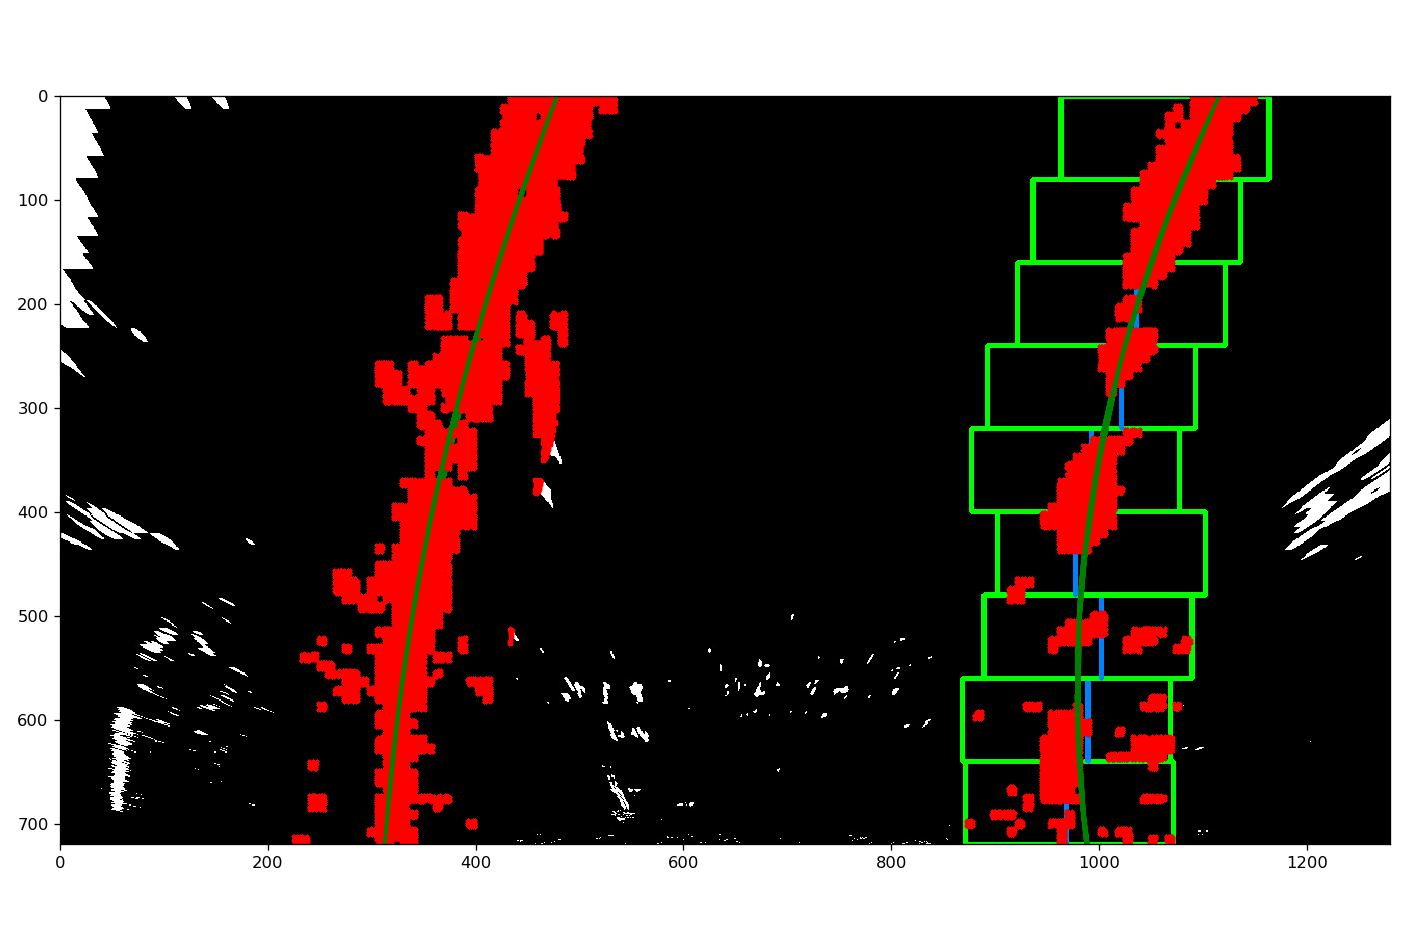

In [52]:
def SelectPixelsUsingSlidingWindow(imgIn, whichLine):    
    margin = 100 # Set the width of the windows +/- margin    
    minpix = 50 # Set minimum number of pixels found to recenter window    
    numWindows = 9 # Number of sliding windows
    
    imageHeight = imgIn.shape[0]
    imageWidth = imgIn.shape[1]
    
    win = type('WindowInfo', (object,), {})  
    win.height = np.int(imageHeight//numWindows)
    win.width = margin * 2
   
    # Take a histogram of the bottom half of the image
    # and find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    if (whichLine == "LEFT"):
        histLeft = 0
        histRight = imageWidth//2
    else:
        histLeft = imageWidth//2
        histRight = imageWidth

    #print("histLR", histLeft, histRight)
    histogram = np.sum(imgIn[imageHeight//2:, : ], axis=0)
    win.centerX = histLeft + np.argmax(histogram[histLeft:histRight])
    
    # Identify the x and y positions of all nonzero pixels in the image    
    pixelsNon0 = imgIn.nonzero()
    pixelsNon0X = np.array(pixelsNon0[1])
    pixelsNon0Y = np.array(pixelsNon0[0])
 
    # Create empty lists to receive left and right lane pixel indices
    selectedPixelIndicesAccum = []

    # Create an output image to draw on for visualizing the result
    imgOut = np.dstack((imgIn, imgIn, imgIn))
    lineWidth = 3
    colorWinRect = (0,255,0)
    colorNextCenterXLine = (0, 130, 255)

    # Loop thru windows
    for windowIndex in range(numWindows):
        #print("======================= processing window: ", window)

        # Identify window boundaries 
        win.bottom = imageHeight - windowIndex * win.height
        win.top = win.bottom - win.height
        win.left = win.centerX -  margin
        win.right = win.centerX +  margin

        # Draw the windows on the visualization image
        cv2.rectangle(imgOut, (win.left, win.bottom), (win.right, win.top), colorWinRect, lineWidth)


        # Identify the nonzero pixels in x and y within the window 
        selectedPixelIndicesCur =  ((pixelsNon0X >= win.left) & (pixelsNon0X < win.right) 
                                   &(pixelsNon0Y >= win.top) & (pixelsNon0Y < win.bottom)).nonzero()[0]

        # Append these indices to the lists
        selectedPixelIndicesAccum.append(selectedPixelIndicesCur)

        #imgWindow = imgIn[win_y_low : win_y_high, win_x_low : win_x_high]
        imgWindow = imgIn[win.top : win.bottom, win.left : win.right]
        pixelsWindow0 = imgWindow.nonzero()
        pixelsWindow0X = pixelsWindow0[1]

        if (len(pixelsWindow0X) > minpix):
            pixelsWindow0XAvg = int(np.mean(pixelsWindow0X))
        else:
            pixelsWindow0XAvg = margin

        nextWindowCenterX = pixelsWindow0XAvg + win.left
        win.centerX = nextWindowCenterX

        Pt0 = (nextWindowCenterX, win.bottom)
        Pt1 = (nextWindowCenterX, win.top)
        cv2.line(imgOut, Pt0, Pt1, colorNextCenterXLine, lineWidth)

 
    # Extract left and right line pixel positions
    selectedPixelIndices = np.concatenate(selectedPixelIndicesAccum)
    selectedPixelsX = pixelsNon0X[selectedPixelIndices]
    selectedPixelsY = pixelsNon0Y[selectedPixelIndices]

    return selectedPixelsX, selectedPixelsY, imgOut

def Test_SelectPixelsUsingSlidingWindow():
    #%matplotlib qt4
    #%matplotlib inline
    %matplotlib notebook
    selectedPixelsX, selectedPixelsY, imgOut = SelectPixelsUsingSlidingWindow(g_imgTest, "RIGHT")
    plt.figure(figsize=(12,8))
    imgOut[selectedPixelsY, selectedPixelsX] = [255, 0, 0]
    plt.imshow(imgOut)
    plt.tight_layout()

g_testImgFileName = "ImagesIn/TestImagesIn/PipelineStages/warped_example.jpg"
g_imgTest = mpimg.imread(g_testImgFileName)
Test_SelectPixelsUsingSlidingWindow()


In [62]:
#left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
#right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

class CImageLine(object):
    
    def __init__(self, name):
        self.prevPolyLine = None
        self.name = name
        self.polyCoeff = None #[ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02]
            
    def HasPolyFit(self):
        hasPolyFit = (self.polyCoeff != None)
        return(hasPolyFit)
    
    def SelectPixelsUsingPolynomial(self, argPolyCoeff, imgIn, selectionWidth = 100):
        # For readability
        coA, coB, coC = argPolyCoeff[0],argPolyCoeff[1],argPolyCoeff[2],
        
        # Find image NonZero pixels
        pixelsNon0 = imgIn.nonzero()
        pixelsNon0X = np.array(pixelsNon0[1])
        pixelsNon0Y = np.array(pixelsNon0[0])

        # Filter in all pixels within +/- margin of the polynomial
        selectedPixelIndices = ((pixelsNon0X > (coA * (pixelsNon0Y**2) + coB * pixelsNon0Y + coC - selectionWidth)) 
                              & (pixelsNon0X < (coA * (pixelsNon0Y**2) + coB * pixelsNon0Y + coC + selectionWidth)))


        # Get the selected pixels
        selectedPixelsX = pixelsNon0X[selectedPixelIndices]
        selectedPixelsY = pixelsNon0Y[selectedPixelIndices] 

        return selectedPixelsX, selectedPixelsY
         
    def CalcPolyFit(self, imgIn):
        imageHeight = imgIn.shape[0]
        selectedCoordsY = np.linspace(0, imageHeight-1, num=imageHeight)

        if (self.HasPolyFit() == True):
            selectedPixelsX, selectedPixelsY = self.SelectPixelsUsingPolynomial(self.polyCoeff, imgIn)
        else:
            # selectedCoordsY, selectedCoordsX = Random_PolyPoints(selectedCoordsY)
            print("No previous polynomial. Searching with sliding window...")
            selectedPixelsX, selectedPixelsY, imgSlidingWindows = SelectPixelsUsingSlidingWindow(imgIn, self.name)

        polyCoeffNew = np.polyfit(selectedPixelsY, selectedPixelsX, 2)       
        PlotSelectedAndPolynomial(polyCoeffNew, selectedPixelsY, selectedPixelsX)
        self.polyCoeff = polyCoeffNew

%matplotlib notebook
#P2Main(g_imageIter)

P2Main.ImgPipeProc:  ImagesIn/TestImagesIn/POVRaw/straight_lines1.jpg
P2Main.LineProc:  LEFT
No previous polynomial. Searching with sliding window...


<IPython.core.display.Javascript object>


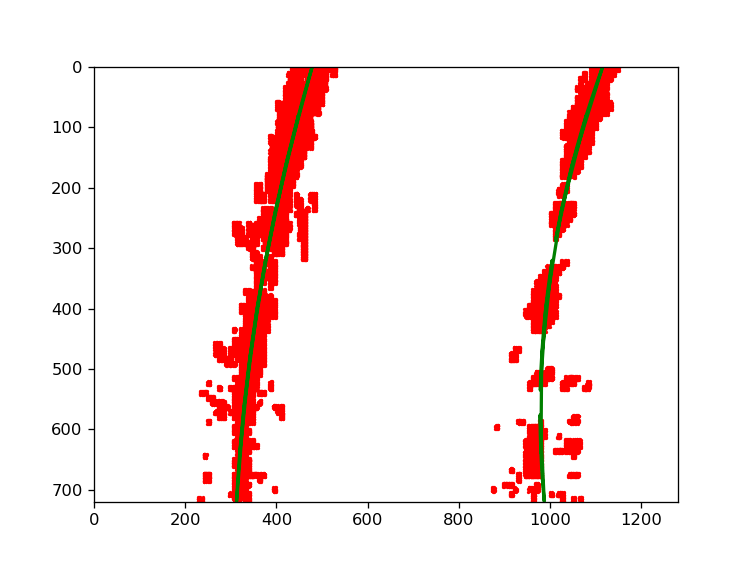

P2Main.LineProc:  RIGHT
No previous polynomial. Searching with sliding window...
 


In [64]:

def P2Main(rawImgSrcIter):

    imageLines = [CImageLine("LEFT"),CImageLine("RIGHT")]
    for (imgRaw, imgRawName) in rawImgSrcIter:
        print("P2Main.ImgPipeProc: ", imgRawName)
        
        imgPipeProc = ImageProc_Pipeline(imgRawName)
        
        for curImageLine in imageLines :
            print("P2Main.LineProc: ", curImageLine.name)
            curImageLine.CalcPolyFit(imgPipeProc)
            
        print(" ")
        
# MainInvocation
g_imageIter = GetImageIteratorFromDir()
P2Main(g_imageIter)